In [1]:
import astropy
from astropy.io import fits
import numpy
from numpy import *
import matplotlib as mpl
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import yt
from scipy.signal import find_peaks
from astropy.cosmology import Planck15 as cosmo
from astropy.convolution import Gaussian1DKernel, convolve_fft

%matplotlib inline

In [2]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = numpy.average(values, weights=weights)
    # Fast and numerically precise:
    variance = numpy.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [3]:
haloname = 'halo_008508'
#simname  = 'nref11n_selfshield_z15'
simname  = 'nref11n_nref10f_selfshield_z6'
DDname   = 'DD1049'

ds = yt.load('/Users/rsimons/Dropbox/rcs_foggie/data/%s/%s/%s/%s'%(haloname, simname, DDname, DDname))
dd = ds.all_data()

print ('/Users/rsimons/Dropbox/rcs_foggie/galprops/%s/%s_%s_galprops.npy'%(haloname, simname, DDname))
galprops = np.load('/Users/rsimons/Dropbox/rcs_foggie/galprops/%s/%s_%s_galprops.npy'%(haloname, simname, DDname), encoding = 'latin1')[()]

cen_xs = galprops['stars_center'][0][0]
cen_ys = galprops['stars_center'][0][1]
cen_zs = galprops['stars_center'][0][2]

cen = yt.YTArray([cen_xs, cen_ys, cen_zs], 'kpc')

print (cen)

yt : [INFO     ] 2019-01-30 01:58:02,657 Parameters: current_time              = 295.31652781829
yt : [INFO     ] 2019-01-30 01:58:02,658 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2019-01-30 01:58:02,660 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-01-30 01:58:02,661 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2019-01-30 01:58:02,662 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2019-01-30 01:58:02,663 Parameters: current_redshift          = 0.90013196382637
yt : [INFO     ] 2019-01-30 01:58:02,664 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2019-01-30 01:58:02,665 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2019-01-30 01:58:02,666 Parameters: hubble_constant           = 0.695


/Users/rsimons/Dropbox/rcs_foggie/galprops/halo_008508/nref11n_nref10f_selfshield_z6_DD1049_galprops.npy
[37277.34211607 36499.94003955 38236.80178441] kpc


In [4]:
def _stars(pfilter, data):
    return data[(pfilter.filtered_type, "particle_type")] == 2


def _youngstars(pfilter, data):
    return data[(pfilter.filtered_type, "age")] < 2.e7


# these are only the must refine dark matter particles
def _darkmatter(pfilter, data):
    return data[(pfilter.filtered_type, "particle_type")] == 4

yt.add_particle_filter("stars",function=_stars, filtered_type='all',requires=["particle_type"])
yt.add_particle_filter("youngstars",function=_youngstars, filtered_type='all',requires=["age"])
yt.add_particle_filter("darkmatter",function=_darkmatter, filtered_type='all',requires=["particle_type"])

ds.add_particle_filter('stars')
ds.add_particle_filter('darkmatter')
ds.add_particle_filter('youngstars')


Parsing Hierarchy : 100%|██████████| 4411/4411 [00:00<00:00, 5335.89it/s]
yt : [INFO     ] 2019-01-30 01:58:05,440 Gathering a field list (this may take a moment.)


True

In [5]:
print ('loading positions')
x_s_box = dd['stars', 'particle_position_x'].in_units('kpc')
y_s_box = dd['stars', 'particle_position_y'].in_units('kpc') 
z_s_box = dd['stars', 'particle_position_z'].in_units('kpc') 

print ('loading velocities')
vx_s_box = dd['stars', 'particle_velocity_x'].in_units('km/s')
vy_s_box = dd['stars', 'particle_velocity_y'].in_units('km/s')
vz_s_box = dd['stars', 'particle_velocity_z'].in_units('km/s')

x_s = x_s_box - cen[0]
y_s = y_s_box - cen[1]
z_s = z_s_box - cen[2]

rd_s = sqrt(x_s**2. + y_s**2. + z_s**2.)

loading positions
loading velocities


In [6]:
ms_s = dd['stars', 'particle_mass'].in_units('Msun')

In [7]:
id_s = dd['stars', 'particle_index']

In [8]:
star_creation_time = dd['stars', 'creation_time'].in_units('yr')
age_s = ds.arr(cosmo.age(ds.current_redshift).value, 'Gyr').in_units('yr') - star_creation_time

In [13]:
xmn, xmx = 0, 100
jmn, jmx = -8, 8
bns = 500

/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/convolution/convolve.py:670: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/convolution/convolve.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = normalized_kernel
/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/convolution/convolve.py:692: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead

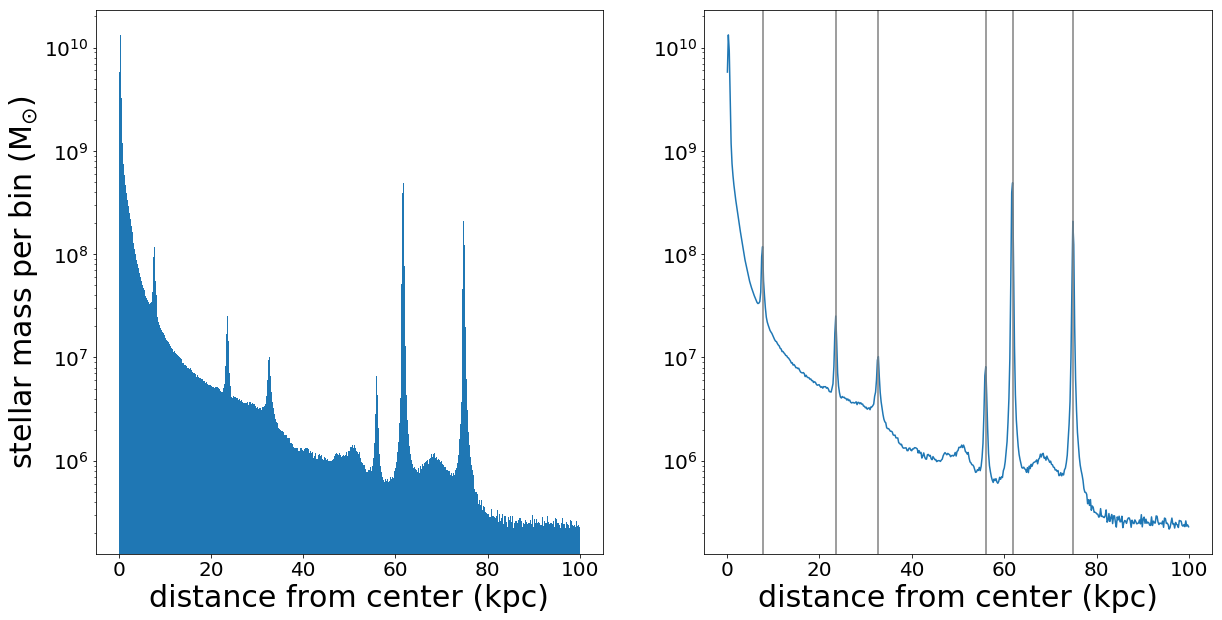

In [61]:
fig, axes = plt.subplots(1,2, figsize = (20,10))

hst_i, edges = histogram(rd_s, weights = ms_s, bins = linspace(0, xmx, bns))

rds = np.mean([edges[0:len(edges) - 1], edges[1:len(edges)]], axis = 0)

axes[0].hist(rd_s, weights = ms_s, bins = linspace(0, xmx, bns))
axes[1].plot(rds, hst_i)

kern = Gaussian1DKernel(0.3*bns/(xmx-xmn))
hst = 10**convolve_fft(log10(hst_i), kern)

peaks, _ = find_peaks(hst, distance = 1.*bns/(xmx-xmn), threshold = 3.e4)
peaks = peaks[1:len(peaks)]

for p in peaks: axes[1].axvline(rds[p], color = 'grey')
    
axes[0].set_ylabel('stellar mass per bin (M$_{\odot}$)', fontsize = 30)

for ax in axes:
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('distance from center (kpc)', fontsize = 30)

7.215430861723448 8.215430861723448
23.047094188376754 24.047094188376754
32.26553106212425 33.26553106212425
55.512024048096194 56.512024048096194
61.32364729458918 62.32364729458918
74.3496993987976 75.3496993987976


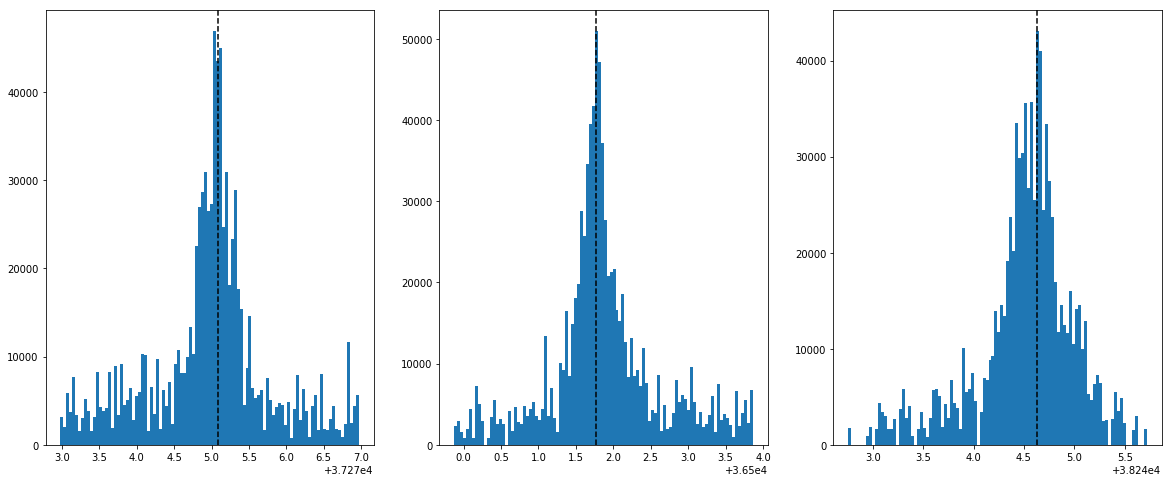

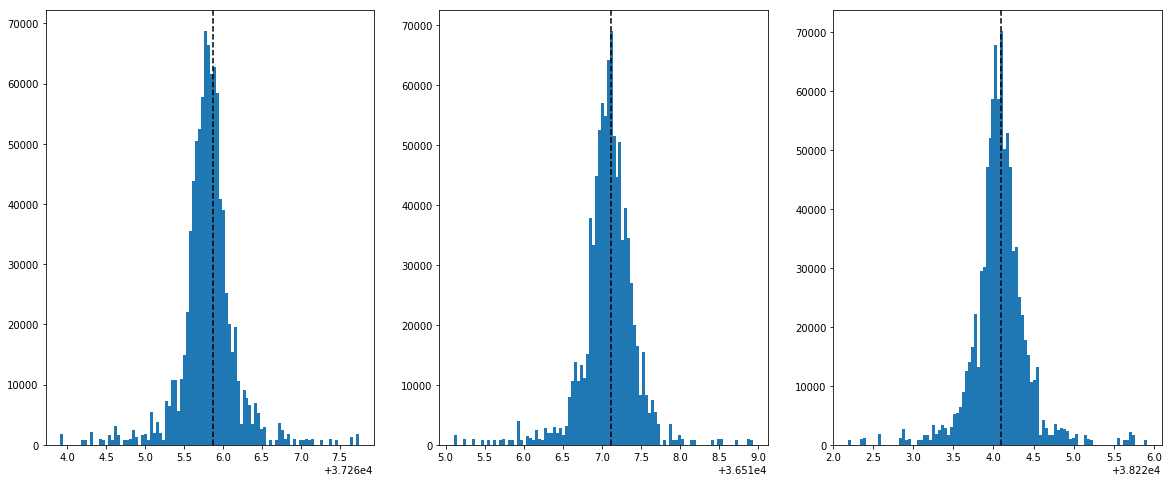

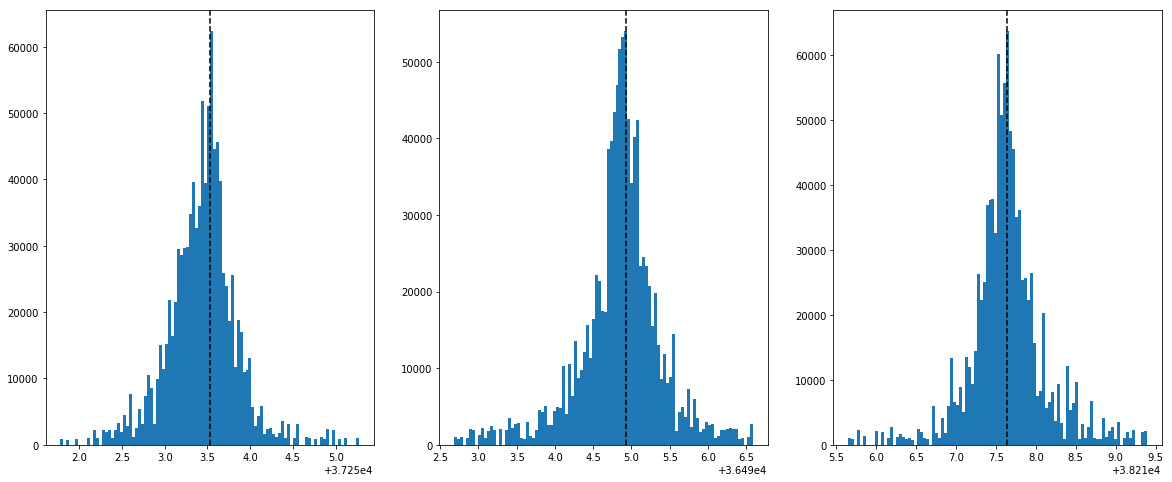

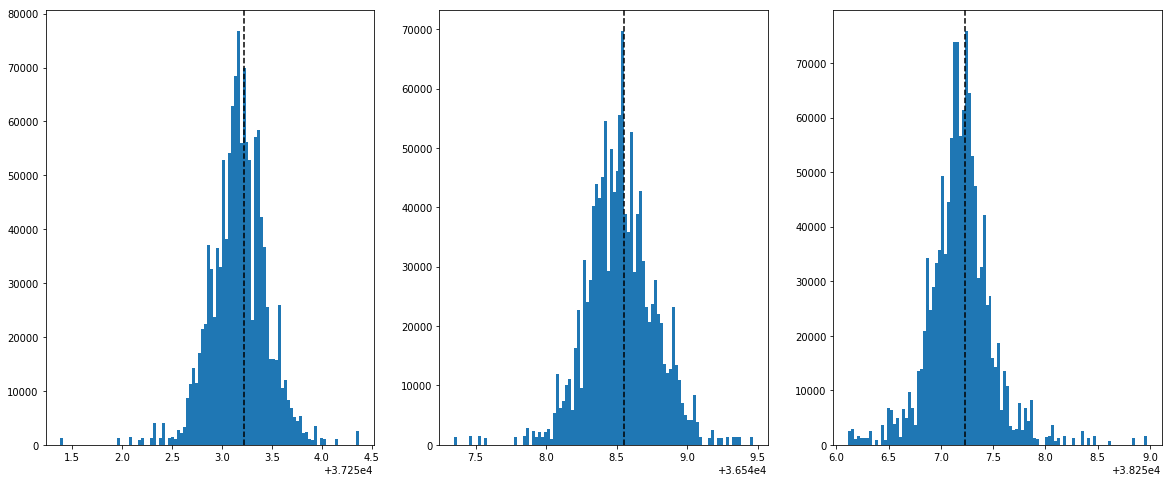

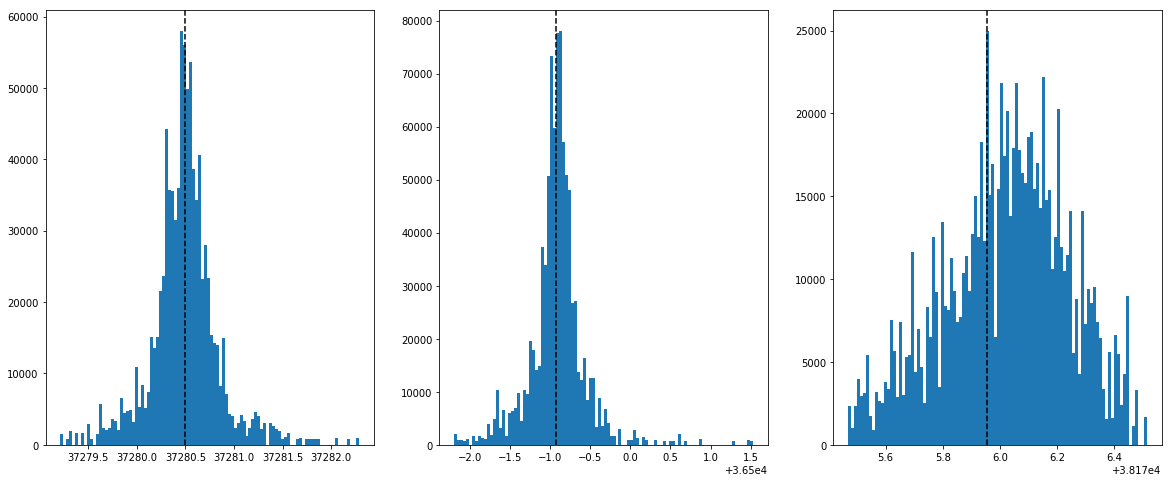

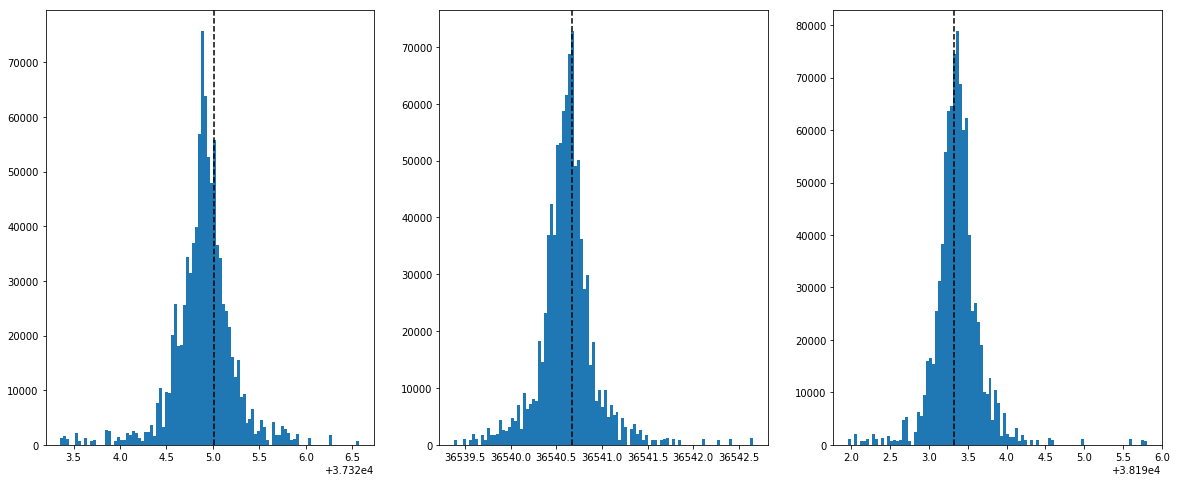

In [62]:
to_save = []
anch_ids = []

for i,p in enumerate(peaks):
    mn_r = rds[p] - 0.5
    mx_r = rds[p] + 0.5
    print (mn_r, mx_r)
    
    in_sel = (rd_s > mn_r) & (rd_s < mx_r)
    
    #x_s_avg, x_s_std = weighted_avg_and_std(x_s[in_sel], weights = ms_s[in_sel])
    #y_s_avg, y_s_std = weighted_avg_and_std(y_s[in_sel], weights = ms_s[in_sel])
    #z_s_avg, z_s_std = weighted_avg_and_std(z_s[in_sel], weights = ms_s[in_sel])

    
    
    
    fig, axes = plt.subplots(1,3, figsize = (20, 8))

    #x_hist = axes[0,0].hist(x_s[in_sel].value, weights = ms_s[in_sel])
    #y_hist = axes[0,1].hist(y_s[in_sel].value, weights = ms_s[in_sel])
    #z_hist = axes[0,2].hist(z_s[in_sel].value, weights = ms_s[in_sel])
    x_hist = histogram(x_s[in_sel].value, weights = ms_s[in_sel], bins = linspace(-mx_r-5, mx_r+5, 100))
    y_hist = histogram(y_s[in_sel].value, weights = ms_s[in_sel], bins = linspace(-mx_r-5, mx_r+5, 100))
    z_hist = histogram(z_s[in_sel].value, weights = ms_s[in_sel], bins = linspace(-mx_r-5, mx_r+5, 100))
    

    x_s_avg = yt.YTArray((x_hist[1][argmax(x_hist[0])] + x_hist[1][argmax(x_hist[0]) + 1])/2., 'kpc')
    y_s_avg = yt.YTArray((y_hist[1][argmax(y_hist[0])] + y_hist[1][argmax(y_hist[0]) + 1])/2., 'kpc')
    z_s_avg = yt.YTArray((z_hist[1][argmax(z_hist[0])] + z_hist[1][argmax(z_hist[0]) + 1])/2., 'kpc')
    
    
    
    


    #print (x_s_avg, x_s_std)
    #print (y_s_avg, y_s_std)
    #print (z_s_avg, z_s_std, '\n')

    good       = where((abs(x_s[in_sel] - x_s_avg) < 2) & 
                       (abs(y_s[in_sel] - y_s_avg) < 2) & 
                       (abs(z_s[in_sel] - z_s_avg) < 2))[0]

    good_ids  = id_s[in_sel][good]
    good_ages = age_s[in_sel][good]
    good_rds = rd_s[in_sel][good]
    good_mss = ms_s[in_sel][good]

    good_xs_box  = x_s_box[in_sel][good]
    good_ys_box  = y_s_box[in_sel][good]
    good_zs_box  = z_s_box[in_sel][good]
    good_vxs_box = vx_s_box[in_sel][good]
    good_vys_box = vy_s_box[in_sel][good]
    good_vzs_box = vz_s_box[in_sel][good]

    anchor_ids       = good_ids[argsort(good_ages)[::-1][0:1000]].astype('int')
    anchor_ages      = good_ages[argsort(good_ages)[::-1][0:1000]]
    anchor_rds       = good_rds[argsort(good_ages)[::-1][0:1000]]
    anchor_mss       = good_mss[argsort(good_ages)[::-1][0:1000]]

    anchor_xs_box    = good_xs_box[argsort(good_ages)[::-1][0:1000]]
    anchor_ys_box    = good_ys_box[argsort(good_ages)[::-1][0:1000]]
    anchor_zs_box    = good_zs_box[argsort(good_ages)[::-1][0:1000]]
    anchor_vxs_box   = good_vxs_box[argsort(good_ages)[::-1][0:1000]]
    anchor_vys_box   = good_vys_box[argsort(good_ages)[::-1][0:1000]]
    anchor_vzs_box   = good_vzs_box[argsort(good_ages)[::-1][0:1000]]

    #anchor_xs_box_avg, _  = weighted_avg_and_std(anchor_xs_box, weights = anchor_mss)
    #anchor_ys_box_avg, _  = weighted_avg_and_std(anchor_ys_box, weights = anchor_mss)
    #anchor_zs_box_avg, _  = weighted_avg_and_std(anchor_zs_box, weights = anchor_mss)
    #anchor_vxs_box_avg, _ = weighted_avg_and_std(anchor_vxs_box, weights = anchor_mss)
    #anchor_vys_box_avg, _ = weighted_avg_and_std(anchor_vys_box, weights = anchor_mss)
    #anchor_vzs_box_avg, _ = weighted_avg_and_std(anchor_vzs_box, weights = anchor_mss)   
    

    x_hist  = np.histogram(anchor_xs_box, weights = anchor_mss, bins = 400)
    y_hist  = np.histogram(anchor_ys_box, weights = anchor_mss, bins = 400)
    z_hist  = np.histogram(anchor_zs_box, weights = anchor_mss, bins = 400)
    vx_hist = np.histogram(anchor_vxs_box, weights = anchor_mss, bins = linspace(-600, 600, 1200))
    vy_hist = np.histogram(anchor_vys_box, weights = anchor_mss, bins = linspace(-600, 600, 1200))
    vz_hist = np.histogram(anchor_vzs_box, weights = anchor_mss, bins = linspace(-600, 600, 1200))
    
    
    #x_s_avg = yt.YTArray((x_hist[1][argmax(x_hist[0])] + x_hist[1][argmax(x_hist[0]) + 1])/2., 'kpc')
    #y_s_avg = yt.YTArray((y_hist[1][argmax(y_hist[0])] + y_hist[1][argmax(y_hist[0]) + 1])/2., 'kpc')
    #z_s_avg = yt.YTArray((z_hist[1][argmax(z_hist[0])] + z_hist[1][argmax(z_hist[0]) + 1])/2., 'kpc')
        
    anchor_xs_box_avg   = yt.YTArray((x_hist[1][argmax(x_hist[0])] + x_hist[1][argmax(x_hist[0]) + 1])/2., 'kpc')
    anchor_ys_box_avg   = yt.YTArray((y_hist[1][argmax(y_hist[0])] + y_hist[1][argmax(y_hist[0]) + 1])/2., 'kpc')
    anchor_zs_box_avg   = yt.YTArray((z_hist[1][argmax(z_hist[0])] + z_hist[1][argmax(z_hist[0]) + 1])/2., 'kpc')
    anchor_vxs_box_avg  = yt.YTArray((vx_hist[1][argmax(vx_hist[0])] + vx_hist[1][argmax(vx_hist[0]) + 1])/2., 'km/s')
    anchor_vys_box_avg  = yt.YTArray((vy_hist[1][argmax(vy_hist[0])] + vy_hist[1][argmax(vy_hist[0]) + 1])/2., 'km/s')
    anchor_vzs_box_avg  = yt.YTArray((vz_hist[1][argmax(vz_hist[0])] + vz_hist[1][argmax(vz_hist[0]) + 1])/2., 'km/s')
    
    
    axes[0].hist(anchor_xs_box.value, weights = anchor_mss, bins = 100)
    axes[1].hist(anchor_ys_box.value, weights = anchor_mss, bins = 100)
    axes[2].hist(anchor_zs_box.value, weights = anchor_mss, bins = 100)
    
    axes[0].axvline(x = anchor_xs_box_avg, color = 'black', linestyle = 'dashed')
    axes[1].axvline(x = anchor_ys_box_avg, color = 'black', linestyle = 'dashed')
    axes[2].axvline(x = anchor_zs_box_avg, color = 'black', linestyle = 'dashed')

    
    anch_ids.append([anchor_ids])
    to_save.append([anchor_xs_box_avg, anchor_ys_box_avg, anchor_zs_box_avg, anchor_vxs_box_avg, anchor_vys_box_avg, anchor_vzs_box_avg])


np.save('/Users/rsimons/Dropbox/rcs_foggie/outputs/%s_anchors.npy'%simname, anch_ids)
np.save('/Users/rsimons/Dropbox/rcs_foggie/outputs/%s_%s_sats.npy'%(simname, DDname), to_save)
    

In [56]:
anchor_xs_box

YTArray([37252.59814816, 37253.38098042, 37253.16278586, 37253.40633586,
         37253.39987862, 37252.85715798, 37253.39957006, 37253.15280798,
         37252.83181666, 37252.87076334, 37253.25302157, 37253.23114944,
         37252.93101958, 37252.94956586, 37253.07879236, 37253.37168169,
         37252.67876789, 37252.95671123, 37253.05216369, 37253.47946007,
         37253.37638768, 37252.99644901, 37253.02095992, 37253.19688764,
         37253.11088977, 37253.27370045, 37253.74366383, 37252.90451179,
         37253.24665882, 37252.90123758, 37252.76810865, 37253.18831137,
         37252.94228056, 37253.03346839, 37252.9971682 , 37253.3791847 ,
         37253.47478609, 37253.11350923, 37253.24658164, 37253.27687359,
         37253.05163838, 37252.93470996, 37253.07318882, 37252.87899473,
         37252.73186012, 37253.2619796 , 37253.36992313, 37252.81066794,
         37252.9641434 , 37253.15645891, 37253.40863652, 37253.21239186,
         37253.44209382, 37253.2052911 , 37253.1660

In [43]:
len(x_hist[1])

11

YTArray([-2.36476458e+09, -2.36476810e+09, -2.36477113e+09, ...,
         -3.45582922e+09, -3.45905511e+09, -3.46187187e+09]) yr

In [14]:
y_s_box

YTArray([36314.83145895, 36361.60190062, 36357.72946434, ...,
         36143.88527771, 36158.05525717, 36147.94747265]) kpc

In [12]:
rad = 5
gc_sphere =  ds.sphere(cen, ds.arr(rad, 'kpc'))

Parsing Hierarchy : 100%|██████████| 1387/1387 [00:00<00:00, 5527.04it/s]
yt : [INFO     ] 2019-01-29 11:23:13,177 Gathering a field list (this may take a moment.)


In [14]:
DM_mass = gc_sphere.quantities.total_quantity([("darkmatter", "particle_mass")]).to('Msun')
gas_mass = gc_sphere.quantities.total_quantity([("gas", "cell_mass")])
gas_metal_mass = gc_sphere.quantities.total_quantity([("gas", "metal_mass")])

stars_mass = gc_sphere.quantities.total_quantity([("stars", "particle_mass")])
youngstars_mass = gc_sphere.quantities.total_quantity([("youngstars", "particle_mass")])





In [2]:
DDnum = 350
#DDnum = 600

a = fits.open('/Users/rsimons/Dropbox/rcs_foggie/outputs/momentum_fits/nref11n_selfshield_z15_DD%.4i_momentum.fits'%DDnum)
a = fits.open('/Users/rsimons/Dropbox/rcs_foggie/outputs/nref11n_nref10f_DD0906_momentum.fits')


#a = fits.open('/Users/rsimons/Dropbox/rcs_foggie/outputs/momentum_fits/nref11n_selfshield_z15_DD0600_momentum.fits')
#a = fits.open('/Users/rsimons/Dropbox/rcs_foggie/outputs/momentum_fits/nref11n_nref10f_selfshield_z6_DD0600_momentum.fits')

In [3]:
ms_s = a['STAR_MASS'].data
age_s = a['STAR_AGE'].data

id_s = a['STARS_ID'].data
rd_s = sqrt(sum(a['STARS_GAL_POSITION'].data**2., axis = 0))
x_s, y_s, z_s = a['STARS_GAL_POSITION'].data
vx_s, vy_s, vz_s = a['STARS_GAL_VELOCITY'].data

x_s_box, y_s_box, z_s_box = a['STARS_BOX_POSITION'].data
vx_s_box, vy_s_box, vz_s_box = a['STARS_BOX_VELOCITY'].data



ep_s = a['STARS_EPSILON_FIXED'].data

ms_d = a['DARK_MASS'].data
rd_d = sqrt(sum(a['DARK_GAL_POSITION'].data**2., axis = 0))
x_d, y_d, z_d = a['DARK_GAL_POSITION'].data
vx_d, vy_d, vz_d = a['DARK_GAL_VELOCITY'].data

ep_d = a['DARK_EPSILON_FIXED'].data



KeyError: "Extension 'STARS_EPSILON_FIXED' not found."

In [8]:
xmn, xmx = 0, 100
jmn, jmx = -8, 8

bns = 500

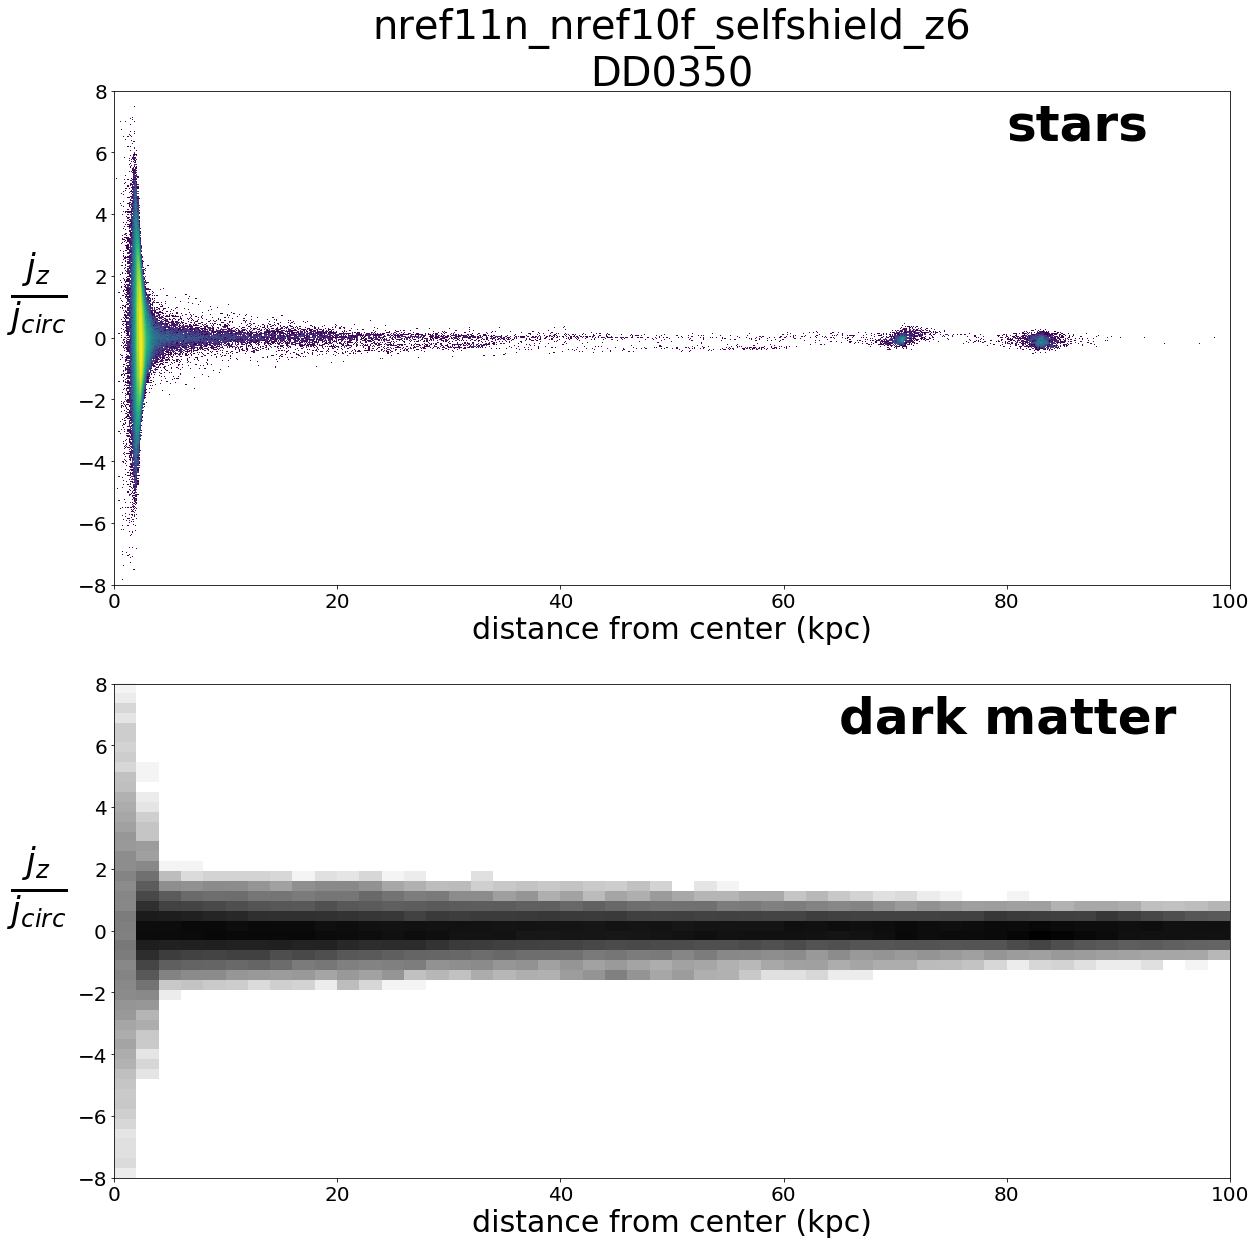

In [9]:
fig, axes = plt.subplots(2,1, figsize = (20,20))




axes[0].hist2d(rd_s, ep_s, range = ([xmn, xmx], [jmn, jmx]), norm = mpl.colors.LogNorm(), cmap = mpl.cm.viridis, bins = 1000)
axes[1].hist2d(rd_d, ep_d, range = ([xmn, xmx], [jmn, jmx]), norm = mpl.colors.LogNorm(), cmap = mpl.cm.Greys, bins = 50)

axes[0].set_title('nref11n_nref10f_selfshield_z6\nDD%Œ.4i'%DDnum, fontsize = 40)
axes[0].annotate('stars', (0.8, 0.9), xycoords = 'axes fraction', fontsize = 50, fontweight = 'bold')
axes[1].annotate('dark matter', (0.65, 0.9), xycoords = 'axes fraction', fontsize = 50, fontweight = 'bold')


for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('distance from center (kpc)', fontsize = 30)
    ax.set_ylabel(r'$\frac{j_{z}}{j_{circ}}$', fontsize = 50, labelpad = 40, rotation = 0)


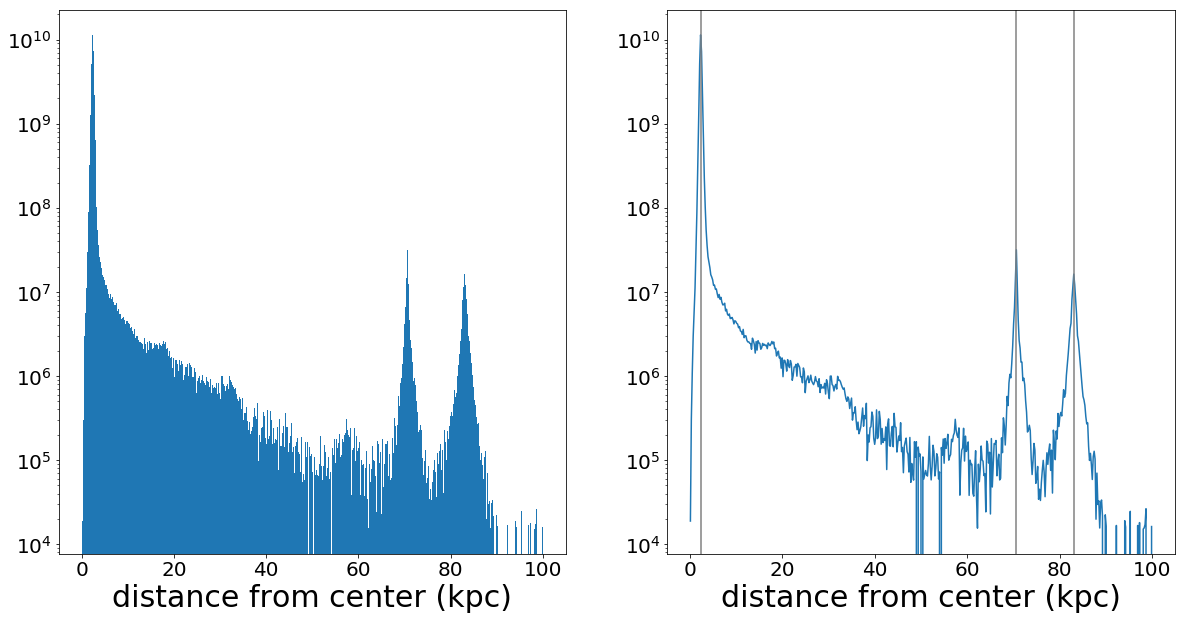

In [10]:
fig, axes = plt.subplots(1,2, figsize = (20,10))

hst, edges = histogram(rd_s, weights = ms_s, bins = linspace(0, xmx, bns))

rds = np.mean([edges[0:len(edges) - 1], edges[1:len(edges)]], axis = 0)


axes[0].hist(rd_s, weights = ms_s, bins = linspace(0, xmx, bns))
axes[1].plot(rds, hst)




peaks, _ = find_peaks(hst, distance = 1.*bns/(xmx-xmn), threshold = 1.e6/(0.2*bns/(xmx-xmn)))

for p in peaks:
    axes[1].axvline(rds[p], color = 'grey')
    


for ax in axes:
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('distance from center (kpc)', fontsize = 30)

    
    
    

In [7]:

peaks_use = peaks[2:len(peaks)]

fig, axes = plt.subplots(len(peaks_use), 1, figsize = (20,10*len(peaks_use)))



bns_2d = 1000


for i,p in enumerate(peaks_use):

    mn_r = rds[p] - 0.5
    mx_r = rds[p] + 0.5

    in_sel = (rd_s > mn_r) & (rd_s < mx_r)
    in_sel_age = (rd_s > mn_r) & (rd_s < mx_r) & (age_s > 2.e9)

    axes[i].hist2d(rd_s, ep_s, range = ([xmn, xmx], [jmn,jmx]), norm = mpl.colors.LogNorm(), cmap = mpl.cm.viridis, bins = bns_2d, alpha = 0.2)

    axes[i].hist2d(rd_s[in_sel], ep_s[in_sel], range = ([xmn, xmx], [jmn,jmx]), norm = mpl.colors.LogNorm(), cmap = mpl.cm.viridis, bins = bns_2d)



    axes[i].annotate('stars', (0.8, 0.9), xycoords = 'axes fraction', fontsize = 50, fontweight = 'bold')
    axes[i].tick_params(axis='both', which='major', labelsize=20)
    axes[i].set_xlabel('distance from center (kpc)', fontsize = 30)
    axes[i].set_ylabel(r'$\frac{j_{z}}{j_{circ}}$', fontsize = 50, labelpad = 40, rotation = 0)




NameError: name 'peaks' is not defined

In [188]:
len(peaks)

10

In [9]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = numpy.average(values, weights=weights)
    # Fast and numerically precise:
    variance = numpy.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

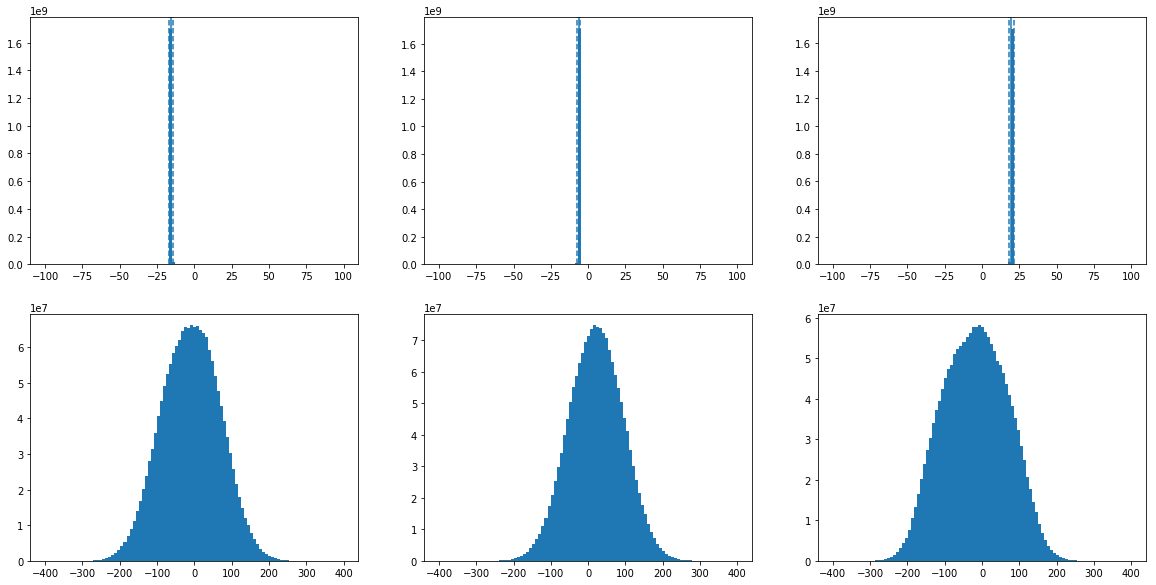

In [10]:
fig, axes = plt.subplots(2,3, figsize = (20, 10))

x_s_avg, x_s_std = weighted_avg_and_std(x_s[in_sel], weights = ms_s[in_sel])
y_s_avg, y_s_std = weighted_avg_and_std(y_s[in_sel], weights = ms_s[in_sel])
z_s_avg, z_s_std = weighted_avg_and_std(z_s[in_sel], weights = ms_s[in_sel])



x_hist = axes[0,0].hist(x_s[in_sel], weights = ms_s[in_sel], bins = linspace(-100, 100, 100))
y_hist = axes[0,1].hist(y_s[in_sel], weights = ms_s[in_sel], bins = linspace(-100, 100, 100))
z_hist = axes[0,2].hist(z_s[in_sel], weights = ms_s[in_sel], bins = linspace(-100, 100, 100))


axes[0,0].axvline(x = x_s_avg)
axes[0,0].axvline(x = x_s_avg + x_s_std, linestyle = 'dashed')
axes[0,0].axvline(x = x_s_avg - x_s_std, linestyle = 'dashed')

axes[0,1].axvline(x = y_s_avg)
axes[0,1].axvline(x = y_s_avg + y_s_std, linestyle = 'dashed')
axes[0,1].axvline(x = y_s_avg - y_s_std, linestyle = 'dashed')

axes[0,2].axvline(x = z_s_avg)
axes[0,2].axvline(x = z_s_avg + z_s_std, linestyle = 'dashed')
axes[0,2].axvline(x = z_s_avg - z_s_std, linestyle = 'dashed')


vx_hist = axes[1,0].hist(vx_s[in_sel], weights = ms_s[in_sel], bins = linspace(-400, 400, 100))
vy_hist = axes[1,1].hist(vy_s[in_sel], weights = ms_s[in_sel], bins = linspace(-400, 400, 100))
vz_hist = axes[1,2].hist(vz_s[in_sel], weights = ms_s[in_sel], bins = linspace(-400, 400, 100))





In [11]:
good       = where((abs(x_s[in_sel] - x_s_avg) < 3 * x_s_std) & 
                   (abs(y_s[in_sel] - y_s_avg) < 3 * y_s_std) & 
                   (abs(z_s[in_sel] - z_s_avg) < 3 * z_s_std))[0]

good_ids  = id_s[in_sel][good]
good_ages = age_s[in_sel][good]
good_rds = rd_s[in_sel][good]
good_mss = ms_s[in_sel][good]


good_xs_box = x_s_box[in_sel][good]
good_ys_box = y_s_box[in_sel][good]
good_zs_box = z_s_box[in_sel][good]
good_vxs_box = vx_s_box[in_sel][good]
good_vys_box = vy_s_box[in_sel][good]
good_vzs_box = vz_s_box[in_sel][good]

anchor_ids  = good_ids[argsort(good_ages)[::-1][0:1000]].astype('int')
anchor_ages = good_ages[argsort(good_ages)[::-1][0:1000]]
anchor_rds  = good_rds[argsort(good_ages)[::-1][0:1000]]
anchor_eps  = good_eps[argsort(good_ages)[::-1][0:1000]]
anchor_mss  = good_mss[argsort(good_ages)[::-1][0:1000]]

anchor_xs_box    = good_xs_box[argsort(good_ages)[::-1][0:1000]]
anchor_ys_box    = good_ys_box[argsort(good_ages)[::-1][0:1000]]
anchor_zs_box    = good_zs_box[argsort(good_ages)[::-1][0:1000]]
anchor_vxs_box  = good_vxs_box[argsort(good_ages)[::-1][0:1000]]
anchor_vys_box  = good_vys_box[argsort(good_ages)[::-1][0:1000]]
anchor_vzs_box  = good_vzs_box[argsort(good_ages)[::-1][0:1000]]

anchor_xs_box_avg, _  = weighted_avg_and_std(anchor_xs_box, weights = anchor_mss)
anchor_ys_box_avg, _  = weighted_avg_and_std(anchor_ys_box, weights = anchor_mss)
anchor_zs_box_avg, _  = weighted_avg_and_std(anchor_zs_box, weights = anchor_mss)
anchor_vxs_box_avg, _ = weighted_avg_and_std(anchor_vxs_box, weights = anchor_mss)
anchor_vys_box_avg, _ = weighted_avg_and_std(anchor_vys_box, weights = anchor_mss)
anchor_vzs_box_avg, _ = weighted_avg_and_std(anchor_vzs_box, weights = anchor_mss)








In [12]:
print 'anchor_xs_box_avg' , anchor_xs_box_avg
print 'anchor_ys_box_avg' , anchor_ys_box_avg
print 'anchor_zs_box_avg' , anchor_zs_box_avg
print 'anchor_vxs_box_avg', anchor_vxs_box_avg
print 'anchor_vys_box_avg', anchor_vys_box_avg
print 'anchor_vzs_box_avg', anchor_vzs_box_avg









anchor_xs_box_avg 26564.85890163585
anchor_ys_box_avg 26236.47388230963
anchor_zs_box_avg 27090.86022165454
anchor_vxs_box_avg -43.430337832552766
anchor_vys_box_avg -116.5351650954063
anchor_vzs_box_avg 49.0334017784708


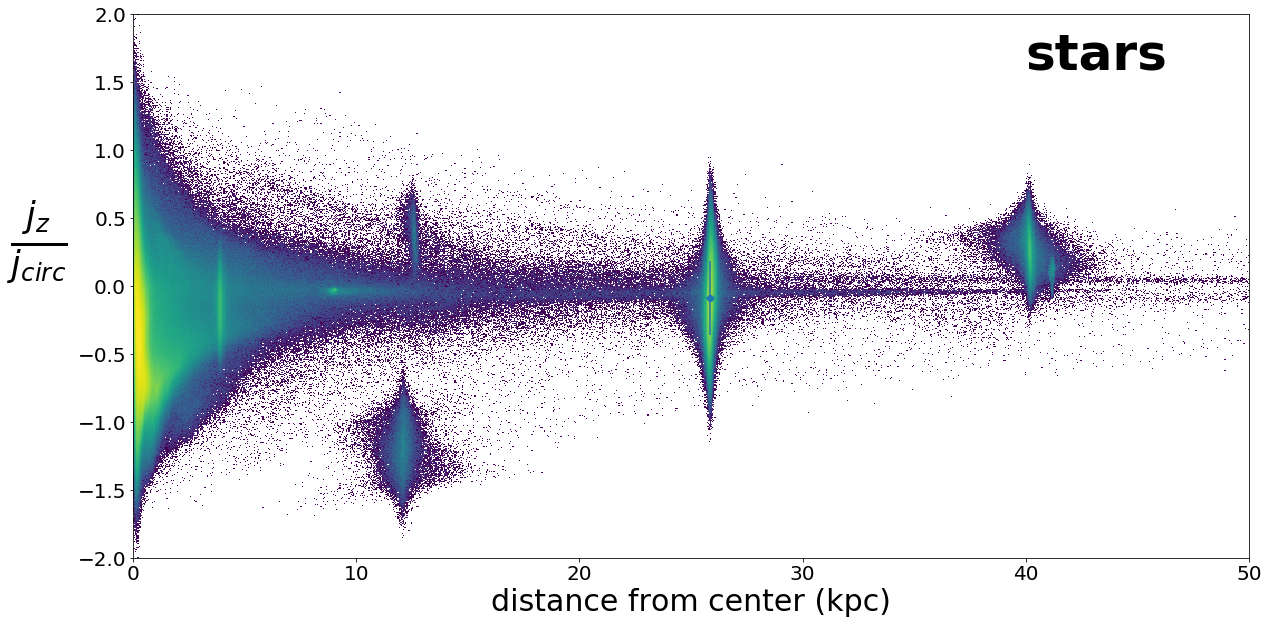

In [13]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
ax.hist2d(rd_s, ep_s, range = ([0, 50], [-2,2]), norm = mpl.colors.LogNorm(), cmap = mpl.cm.viridis, bins = 1000, alpha = 1.0)


avg_r, std_r = weighted_avg_and_std(anchor_rds, weights = anchor_mss)
avg_e, std_e = weighted_avg_and_std(anchor_eps, weights = anchor_mss)



ax.errorbar(avg_r, avg_e, xerr = std_r, yerr = std_e, marker = 'o')


ax.annotate('stars', (0.8, 0.9), xycoords = 'axes fraction', fontsize = 50, fontweight = 'bold')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('distance from center (kpc)', fontsize = 30)
ax.set_ylabel(r'$\frac{j_{z}}{j_{circ}}$', fontsize = 50, labelpad = 40, rotation = 0)




np.save('/Users/rsimons/Dropbox/rcs_foggie/outputs/nref11n_nref10f_selfshield_z6_anchors.npy', anchor_ids)




In [ ]:
anchor_ids = np.load('/Users/rsimons/Dropbox/rcs_foggie/outputs/nref11n_nref10f_selfshield_z6_anchors.npy')[()]

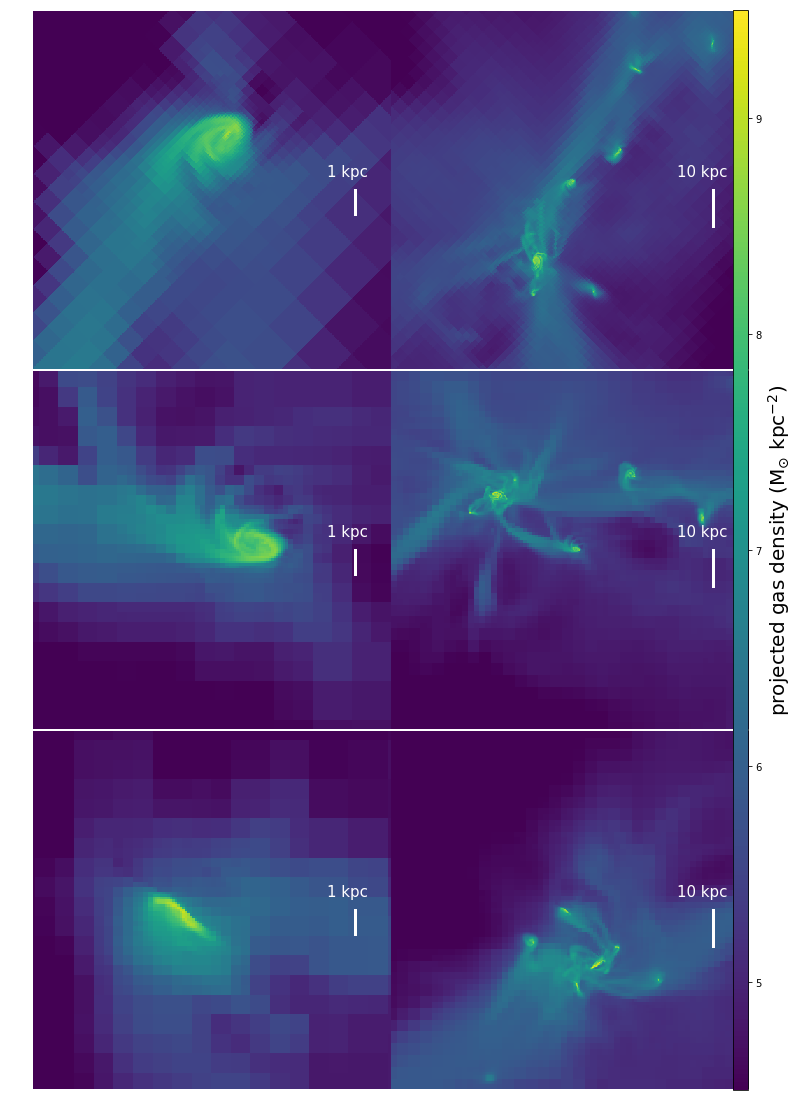

In [49]:
Ls = [[1,0,0], [0,1,0], [0, 0, 1]]

W1 = yt.YTArray([15, 15, 15], 'kpc')
W2 = yt.YTArray([100, 100, 100], 'kpc')

north_vector = [0,0.7,0.7]
N = 512


anchor_xs_box_avg = 26564.85890163585
anchor_ys_box_avg = 26236.47388230963
anchor_zs_box_avg = 27090.86022165454
cen = yt.YTArray([anchor_xs_box_avg, anchor_ys_box_avg, anchor_zs_box_avg], 'kpc')


fig, axes = plt.subplots(3,2, figsize = (10.8, 15))



for i in arange(3):
    L = Ls[i]
    image1 = yt.off_axis_projection(ds, cen, L, W1, N, ('gas', 'density'), north_vector =  north_vector)
    image2 = yt.off_axis_projection(ds, cen, L, W2, N, ('gas', 'density'), north_vector =  north_vector)


    image1 = image1.in_units('Msun * kpc**-2')
    image2 = image2.in_units('Msun * kpc**-2')

    im1 = axes[i, 0].imshow(np.log10(image1), vmin = 4.5, vmax = 9.5)
    im2 = axes[i, 1].imshow(np.log10(image2), vmin = 4.5, vmax = 9.5)


    bar_len_kpc = 1.
    bar_len_pix = 1.*N/W1[0].value * bar_len_kpc
    y_bar_start_pix = 0.5*N
    y_bar_end_pix = y_bar_start_pix + bar_len_pix
    x_bar_pix = 0.9*N
    axes[i, 0].plot([x_bar_pix, x_bar_pix], [y_bar_start_pix, y_bar_end_pix], color = 'white', linewidth = 3)
    axes[i, 0].annotate("%i kpc"%bar_len_kpc, (x_bar_pix-0.08*N, y_bar_start_pix- 0.04*N), color = 'white', fontsize = 15, rotation = 0)



    bar_len_kpc = 10
    bar_len_pix = 1.*N/W2[0].value * bar_len_kpc
    y_bar_start_pix = 0.5*N
    y_bar_end_pix = y_bar_start_pix + bar_len_pix
    x_bar_pix = 0.9*N
    axes[i, 1].plot([x_bar_pix, x_bar_pix], [y_bar_start_pix, y_bar_end_pix], color = 'white', linewidth = 3)
    axes[i, 1].annotate("%i kpc"%bar_len_kpc, (x_bar_pix-0.10*N, y_bar_start_pix- 0.04*N), color = 'white', fontsize = 15, rotation = 0)






for ax in axes.ravel():
    ax.axis('off')

cax = fig.add_axes([0.90, 0.0, 0.02, 1.0])
cbr = fig.colorbar(im1, cax=cax,orientation="vertical")

cbr.set_label('projected gas density (M$_{\odot}$ kpc$^{-2}$)', fontsize = 20)
fig.subplots_adjust(left = 0.0, right = 0.92, top =1.0, bottom = 0.0, hspace = 0.0, wspace = 0.0)

In [47]:
cbr.


AttributeError: 'Colorbar' object has no attribute 'ticks'